# Moledetection



Trial 3 Complete [00h 16m 14s]
val_loss: 1.9976115226745605

Best val_loss So Far: 1.1747444868087769
Total elapsed time: 00h 16m 14s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 1s 51ms/step - loss: 1.9476 - accuracy: 0.1714
INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets
6/6 [==============================] - 0s 13ms/step - loss: 1.8770 - accuracy: 0.1916
Accuracy =  19.161677360534668 %
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)     

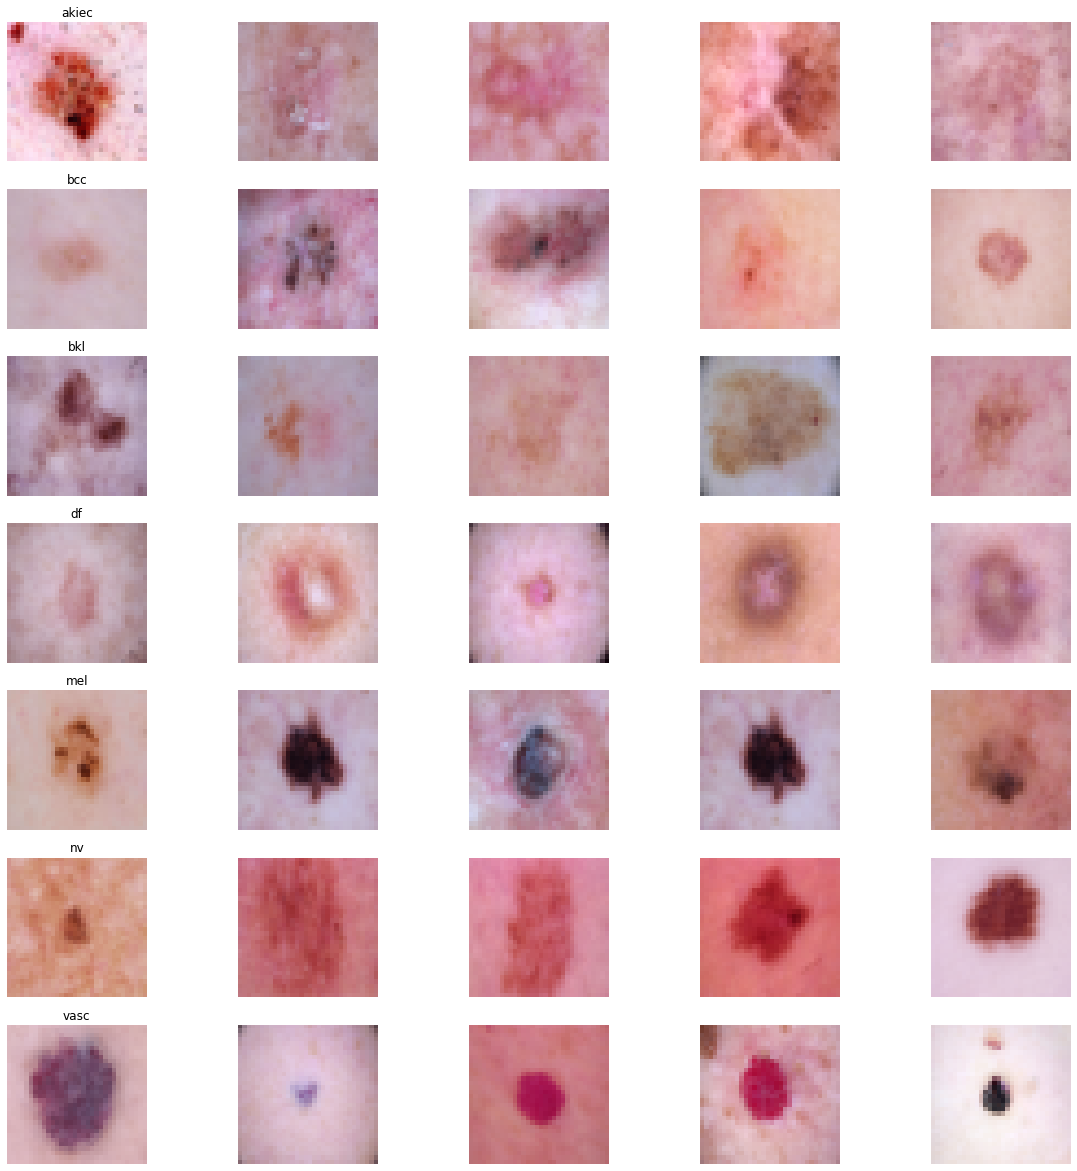

In [1]:
# 
"""
Skin cancer lesion classification using the HAM10000 dataset
Autokeras to find the best model. 
Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)

labels=['nv','mel','bkl','bcc','akiec','vas','df']
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

skin_df = pd.read_csv('../data/HAM10000/HAM10000_metadata.csv')


SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../data/HAM10000/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))



n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

#Further split data into smaller size to get a small test dataset. 
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)

#Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
clf = ak.ImageClassifier(max_trials=1) #MaxTrials - max. number of keras models to try
clf.fit(x_train_auto, y_train_auto, epochs=1)


#Evaluate the classifier on test data
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

# get the final best performing model
model = clf.export_model()
print(model.summary())

#Save the model
model.save('cifar_model.h999')


score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])

In [38]:
skin_df = pd.read_csv('../data/HAM10000/HAM10000_metadata.csv')
L=int(len(skin_df)*0.1)
skin_df.head(int(len(skin_df)*0.1))

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
996,HAM_0005834,ISIC_0032249,bkl,consensus,45.0,male,lower extremity
997,HAM_0005136,ISIC_0024337,bkl,consensus,50.0,female,lower extremity
998,HAM_0004308,ISIC_0027370,bkl,consensus,50.0,female,back
999,HAM_0004078,ISIC_0026566,bkl,consensus,70.0,female,trunk


In [1]:
## SECOND TRIAL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

import tensorflow as tf
from tensorflow import keras



#################################################################################################################


np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

skin_df = pd.read_csv('../data/HAM10000/HAM10000_metadata.csv')


#SIZE=32
SIZE=32


# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]


Lh=int(len(df_0)*0.1)
Lt=len(df_0)-Lh
df_0_aside=df_0.head(Lh)
df_0=df_0.tail(Lt)

Lh=int(len(df_1)*0.1)
Lt=len(df_1)-Lh
df_1_aside=df_1.head(Lh)
df_1=df_1.tail(Lt)

Lh=int(len(df_2)*0.1)
Lt=len(df_2)-Lh
df_2_aside=df_2.head(Lh)
df_2=df_2.tail(Lt)

Lh=int(len(df_3)*0.1)
Lt=len(df_3)-Lh
df_3_aside=df_3.head(Lh)
df_3=df_3.tail(Lt)

Lh=int(len(df_4)*0.1)
Lt=len(df_4)-Lh
df_4_aside=df_4.head(Lh)
df_4=df_4.tail(Lt)

Lh=int(len(df_5)*0.1)
Lt=len(df_5)-Lh
df_5_aside=df_5.head(Lh)
df_5=df_5.tail(Lt)

Lh=int(len(df_6)*0.1)
Lt=len(df_6)-Lh
df_6_aside=df_6.head(Lh)
df_6=df_6.tail(Lt)

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../backup/data/HAM10000/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))



ModuleNotFoundError: No module named 'keras'

In [ ]:
skin_df_balanced.head()

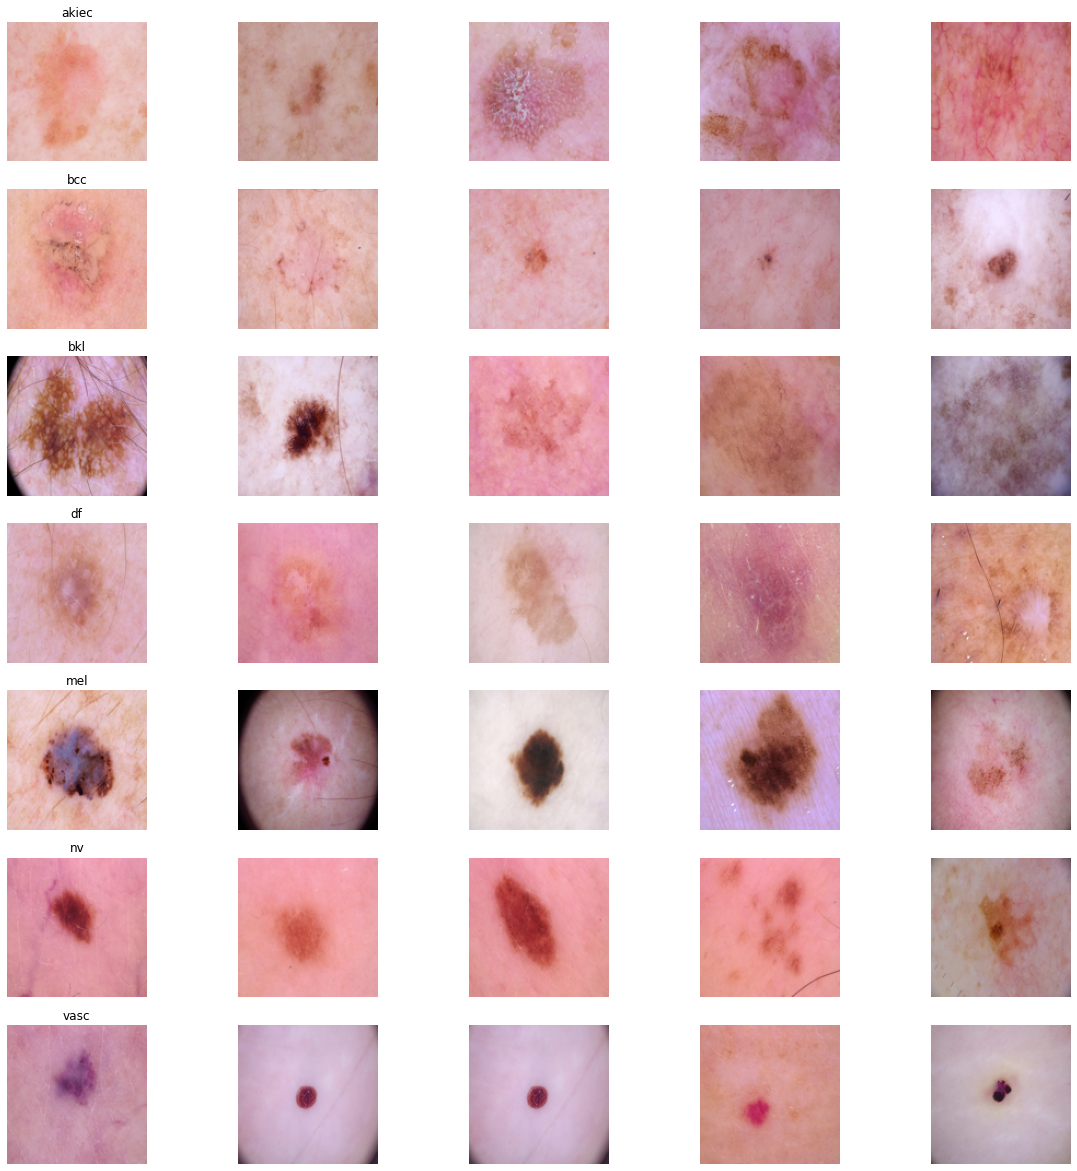

In [27]:


n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem


In [28]:

##################################################################################################################
print("@@@@3@@@@@")
#Split to training and testing. 
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

#Further split data into smaller size to get a small test dataset. 
#x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)
print("@@@@1@@@@@")
#Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
clf = ak.ImageClassifier(max_trials=10) #MaxTrials - max. number of keras models to try
clf.fit(x_train, y_train, epochs=5)


print("@@@@2@@@@@")
#Evaluate the classifier on test data
_, acc = clf.evaluate(x_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

# get the final best performing model
model = clf.export_model()
print(model.summary())

#Save the model
model.save('cifar_model.h9999')
#load the model
model=tf.keras.models.load_model('cifar_model.h128')

# get the final best performing model
#model = clf.export_model()
print(model.summary())

#Evaluate the classifier on test data
#_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

#score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])



Trial 5 Complete [00h 02m 20s]
val_loss: 1.171741247177124

Best val_loss So Far: 0.9295234680175781
Total elapsed time: 00h 04m 18s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
88/88 [==============================] - 73s 820ms/step - loss: 2.1778 - accuracy: 0.3279
Epoch 2/2
88/88 [==============================] - 84s 954ms/step - loss: 1.0330 - accuracy: 0.6421
INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets
@@@@2@@@@@
22/22 [==============================] - 6s 243ms/step - loss: 0.8869 - accuracy: 0.6957
Accuracy =  69.57142949104309 %
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 128, 128, 3)      0         
 t32)                                                            
              

In [29]:
_, acc = clf.evaluate(x_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

# get the final best performing model
model = clf.export_model()
print(model.summary())

#Save the model
model.save('cifar_model.h128_4')
#load the model
tf.keras.models.load_model('cifar_model.h128_4')

# get the final best performing model
#model = clf.export_model()
#print(model.summary())

#Evaluate the classifier on test data
#_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")


22/22 [==============================] - 4s 158ms/step - loss: 0.8869 - accuracy: 0.6957
Accuracy =  69.57142949104309 %
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 128, 128, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 128, 128, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
      

In [30]:

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score)
#########END TRIAL2

22/22 [==============================] - 4s 174ms/step - loss: 0.8869 - accuracy: 0.6957
Test accuracy: [0.886949360370636, 0.6957142949104309]


In [2]:
# Predict the class of your picture.
# prediction = new_model.predict(...
## SECOND TRIAL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

import tensorflow as tf
from tensorflow import keras
import cv2

# example of loading an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img



#load the model
model=tf.keras.models.load_model('cifar_model.h128_3')

# load the image
img1 = load_img('../pybin/images/ISIC_0024306.jpg')


def predictimage(img,model):
    # report details about the image
    print(type(img))
    print(img.format)
    print(img.mode)
    print(img.size)
    # show the image
    img.show()

    # convert to numpy array
    img = img_to_array(img)
    img = cv2.resize(img, (128, 128))
    img=np.reshape(img, (-1, 128, 128, 3)) 

    #predict
    result=model.predict(img)
    result=result[0]
    
    # label encoding to numeric values from text
    #le = LabelEncoder()
    #le.fit(skin_df['dx'])
    #LabelEncoder()
    #print(type(le.classes_[5]))
    for i in range(7):
        if result[i] == 1:
            break
    return str(le.classes_[i])
    
    
    
res=predictimage(img1,model)
print(res)

# label encoding to numeric values from text
#le = LabelEncoder()
#le.fit(skin_df['dx'])
#LabelEncoder()
#print(list(le.classes_))
 
#skin_df['label'] = le.transform(skin_df["dx"]) 
#print(skin_df.sample(10))

#The 7 classes of skin cancer lesions included in this dataset are:
seven={
        'nv':'Melanocytic nevi',
        'mel':'Melanoma',
        'bkl':'Benign keratosis-like lesions',
        'bcc':'Basal cell carcinoma',
        'akiec':'Actinic keratoses',
        'vas':'Vascular lesions',
        'df':'Dermatofibroma'
        }

print(seven[res])


ModuleNotFoundError: No module named 'keras'

In [31]:



print("############################################################################")
####################
# Compile and fit the model. Use the Adam optimizer and crossentropical loss. 
# Use the validation data argument during fitting to include your validation data.
#model.compile(optimizer='adam',
#                  loss='binary_crossentropy',
#                  metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=20)


#Save the model
model.save('cifar_model.h6')
# get the final best performing model
#model = clf.export_model()
print(model.summary())

#Evaluate the classifier on test data
_, acc = model.evaluate(x_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1],score)
print("############################################################################")

############################################################################
Epoch 1/20
88/88 [==============================] - 62s 700ms/step - loss: 0.5692 - accuracy: 0.8146
Epoch 2/20
88/88 [==============================] - 73s 831ms/step - loss: 0.2452 - accuracy: 0.9311
Epoch 3/20
88/88 [==============================] - 75s 852ms/step - loss: 0.1237 - accuracy: 0.9679
Epoch 4/20
88/88 [==============================] - 78s 888ms/step - loss: 0.0624 - accuracy: 0.9843
Epoch 5/20
88/88 [==============================] - 76s 868ms/step - loss: 0.0390 - accuracy: 0.9900
Epoch 6/20
88/88 [==============================] - 75s 857ms/step - loss: 0.0332 - accuracy: 0.9918
Epoch 7/20
88/88 [==============================] - 76s 859ms/step - loss: 0.0356 - accuracy: 0.9904
Epoch 8/20
88/88 [==============================] - 77s 880ms/step - loss: 0.0239 - accuracy: 0.9929
Epoch 9/20
88/88 [==============================] - 76s 864ms/step - loss: 0.0209 - accuracy: 0.9939
Epoch 10/20
88

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\bmadmin\anaconda3\envs\mole_detection\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


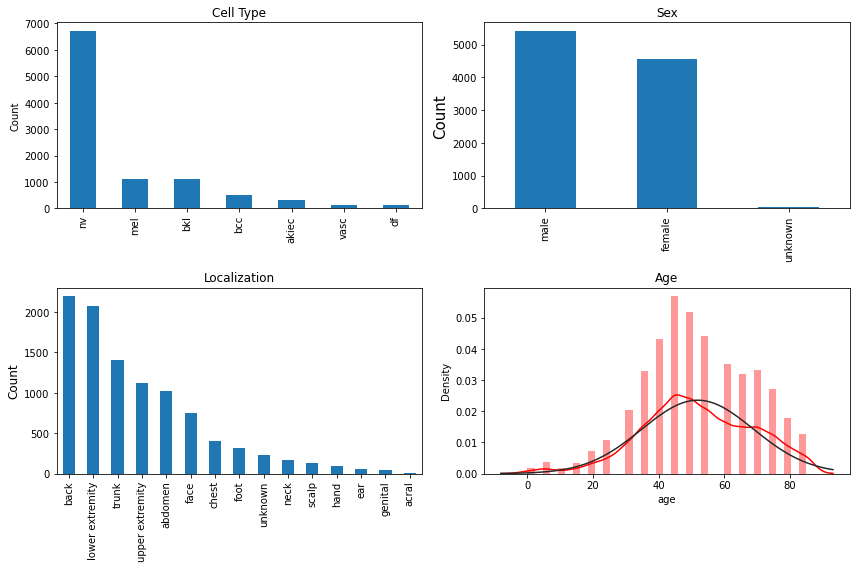

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)        0         
 

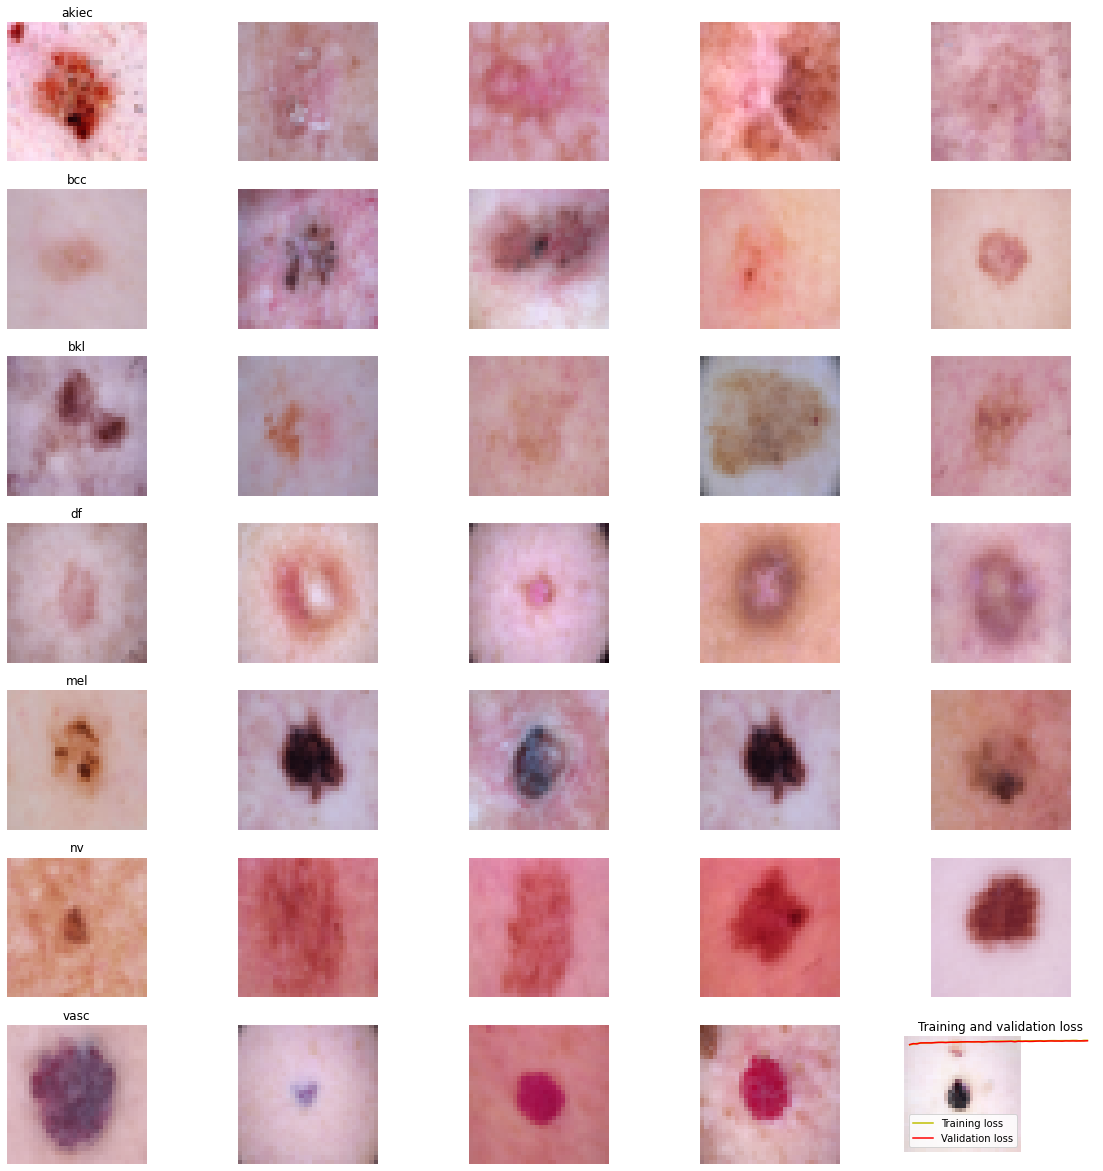

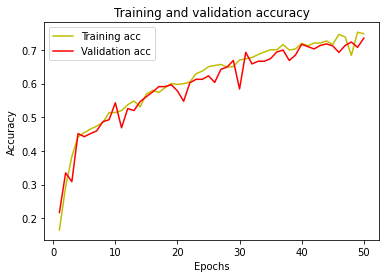

Text(34.0, 0.5, 'Fraction of incorrect predictions')

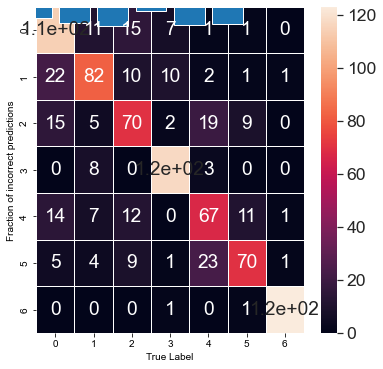

In [43]:
# 
"""
Skin cancer lesion classification using the HAM10000 dataset
Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df = pd.read_csv('../data/HAM10000/HAM10000_metadata.csv')

SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())


#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../data/HAM10000/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

### Preparing your images

### 1.3 Predicting the class of your image

Let's take this bad boy for a spin! Can your image get properly identified? Finish the code down below and find out!

So, how did we do? your final result should return a general label of the object in the picture, but the performance might not be up to your expectation. Why is this? 

This could be due to the fact that these are general object recognition models, they are trained on **a lot** of image, but also a lot of different classes of images. What would happen if you took the best part of your pre-trained network, and adapt the output to specialize to just a few of your own chosen classes? Let's check this out in the next part...

## 2. Transfer learning

Many of the steps of pre-trained model learning still apply to transfer learning, but this time around, we're going to use our own dataset to help the model specialize in a particular subject.

Take a look at the image below: 
![low-to-high](./../assets/low-to-high.png)

It shows how a particular object is recognized at the different stages of a CNN. With our pre-trained CNN, it's no different. Instead of retraining a full neural network to extract low-level features such as lines, or other common patterns, we **keep the general feature extraction** of a pre-trained network and **replace the nonlinear association of features** done in the last few dense layers of the network.

Some features may be shared by multiple classes in our use case (with animals, this is often the case), while others are only specific to a single class of the network. That's quite okay though, even if the model has been trained to extract features from classes not present in the final set of classes, this is training you don't have to redo anyway. The only difference is a small redundancy and (non-noticeable) slowdown during model prediction because of the larger model size.

So in short, the advantages of transfer learning are:
- No need to train a whole model from scratch
- less training data required (less DOF(degrees of freedom) to fill)
- lower level feature extraction from pre-trained networks can be reused
- output classes can be changed

### 2.1 Importing and preprocessing the data

Having a general model is all fine and dandy, but I want to **relax** the object identification problem by **reducing** the amount of classes in our model. I want a model that can accurately **identify hot dogs** from not hot dogs!

Go and download the data from [this Kaggle dataset](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog), and go through the motions of preparing the data for our model.

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os

def get_preprocessed_images(images_directory: str, image_size: tuple) -> list:
    images = []
    for img in os.listdir(images_directory):
        img = image.load_img(images_directory+img, target_size=image_size)
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        images.append(img)
    return np.vstack(images)

In [1]:
# Import the keras preprocessing method.
from tensorflow.keras.preprocessing import image

# Load your images and preprocess them.
hot_dog_images = get_preprocessed_images("./../assets/full/hot_dog/", image_size)
non_hot_dog_images = get_preprocessed_images("./../assets/full/not_hot_dog/", image_size)

# Make a numpy array for each of the class labels (one hot encoded).
hot_dog_labels = np.tile([1, 0], (hot_dog_images.shape[0], 1))
non_hot_dog_labels = np.tile([0, 1], (non_hot_dog_images.shape[0], 1))

# Concatenate your images and your labels into X and y.
X = np.concatenate([hot_dog_images, non_hot_dog_images])
y = np.concatenate([hot_dog_labels, non_hot_dog_labels])

print(X.shape, y.shape)

NameError: name 'get_preprocessed_images' is not defined

As always when training a model, we need to split our data in a train and a test set. For deep learning, a validation set is oftentimes used as well. Kind of foggy on the [different purposes](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) of these sets?

In [163]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

### 2.2 Augmenting the data

We don't have that many hot dogs to look at, let's squeeze as much information out of the training data by augmenting them.

In [183]:
from keras.preprocessing.image import ImageDataGenerator

# Determine the number of generated samples you want per original sample.
datagen_batch_size = 16

# Make a datagenerator object using ImageDataGenerator.
train_datagen = ImageDataGenerator(rotation_range=60,
                                    horizontal_flip=True)

# Feed the generator your train data.
train_generator = train_datagen.flow(X_train, y_train, batch_size=datagen_batch_size)

# Make a datagenerator object using ImageDataGenerator.
validation_datagen = ImageDataGenerator(rotation_range=60,
                                        horizontal_flip=True)

# Feed the generator your validation data.
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=datagen_batch_size)

### 2.3 Importing part of an existing model

Let's import one of the application of the keras library, but make sure you don't import the final layers (the dense layers used to associate features). 

In [3]:
# Import your chosen model!
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Make a model object. 
# Make sure you exclude the top part. set the input shape of the model to 224x224 pixels, with 3 color channels.
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the imported layers so they cannot be retrained.
for layer in model.layers:
    layer.trainable = False
    
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### 2.4 Adding flattening and dense layers

Right now, our model is missing a top to actually classify our features. Let's add them:

In [4]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(2, activation='sigmoid'))

# Summarize.
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4014144   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 6,272,258
Trainable params: 4,014,274
Non-trainable params: 2,257,984
_________________________________________________________________


### 2.5 Training and evaluating the model

All that's left to do is to train the model!

In [186]:
# Compile and fit the model. Use the Adam optimizer and crossentropical loss. 
# Use the validation data argument during fitting to include your validation data.
new_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
history = new_model.fit(train_generator,
                        epochs=10, 
                        batch_size=8,
                        validation_data=validation_generator
                       )

Epoch 1/10
20/20 [==============================] - 9s 428ms/step - loss: 2.3265 - accuracy: 0.8219 - val_loss: 0.9004 - val_accuracy: 0.8125
Epoch 2/10
20/20 [==============================] - 9s 464ms/step - loss: 0.3906 - accuracy: 0.9031 - val_loss: 0.2944 - val_accuracy: 0.8250
Epoch 3/10
20/20 [==============================] - 9s 460ms/step - loss: 0.3090 - accuracy: 0.8938 - val_loss: 0.4981 - val_accuracy: 0.8625
Epoch 4/10
20/20 [==============================] - 9s 459ms/step - loss: 0.1936 - accuracy: 0.9250 - val_loss: 0.5408 - val_accuracy: 0.8750
Epoch 5/10
20/20 [==============================] - 9s 458ms/step - loss: 0.3315 - accuracy: 0.9000 - val_loss: 0.3848 - val_accuracy: 0.8375
Epoch 6/10
20/20 [==============================] - 9s 459ms/step - loss: 0.3471 - accuracy: 0.9031 - val_loss: 0.4125 - val_accuracy: 0.9000
Epoch 7/10
20/20 [==============================] - 10s 477ms/step - loss: 0.2482 - accuracy: 0.9281 - val_loss: 0.4145 - val_accuracy: 0.8375
Epoch

Now, let's see how you did with this handy helper function!

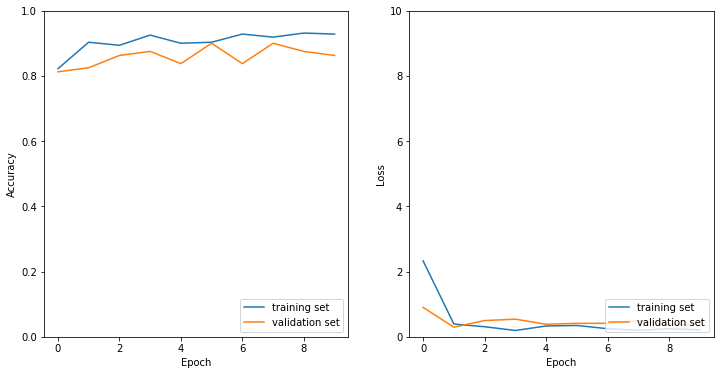

In [187]:
import tensorflow

def plot_history(history : tensorflow.python.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)